<h1>Esto es para Eitan</h1>

usar nbdime para hacer merges en el codigo con github

<h2>Fase 1: Business Understanding</h2>



El banco Monopoly lleva muchos años atendiendo a sus clientes en Chile y recientemente ha sido adquirido por un Banco con capitales extranjeros llamado “Dormammu”. Dormammu nos ha encargado hacer estudios sobre los clientes del banco Monopoly, para conocer su comportamiento y detectar patrones. Además, debemos analizar cómo será su estrategia para abordar estos nuevos clientes dado el uso que ellos hacen de sus productos financieros.

Nosotros vamos a analizar su base de datos, limpiarla, seleccionar las variables que sirvan para alguna interpretación y entregar la mayor información posible a los dueños de este banco para que puedan conocer a los clientes, preparar una estrategia y abordar a este nuevo mercado.

Nuestro objetivo será ver si sus clientes pagan sus cuentas al día.
Para nuesstro modelo de clasificación utilizaremos la variable Paga_al_dia
Para nuuestro modelo de regresión utilizaremos Tota_monto_pagado


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

#%matplotlib inline

In [ ]:
#Link de Base de datos https://docs.google.com/spreadsheets/d/1fq30bn_G8wN4vyAvLOjFcYi0yYZft3PC/edit?usp=sharing&ouid=112329233676406678155&rtpof=true&sd=true

In [2]:
MONOPOLY_XLSX ='Base_clientes_Monopoly.xlsx'
MONOPOLY_CSV ='Base_clientes_Monopoly_otro.csv'

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
df = pd.read_excel(MONOPOLY_XLSX)
df.head(10)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,...,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0
5,6,170,H,13.0,47,707664.0,67,1,1,0,...,0.0,35800,0.0,35800.0,0.0,0.0,51197,0.0,R,0
6,7,811,H,13.0,48,1022833.0,21,1,0,1,...,0.0,9391,0.0,8818.0,0.0,8818.0,0,0.0,T,0
7,8,170,H,13.0,46,NaN,69,0,1,1,...,0.0,6000,0.0,283520.0,0.0,283520.0,0,0.0,R,0
8,9,170,H,13.0,49,1171066.0,33,0,0,0,...,0.0,60000,0.0,507629.0,0.0,507629.0,0,0.0,R,1
9,10,170,M,13.0,44,964387.0,23,1,1,0,...,0.0,92583,0.0,65487.0,0.0,65487.0,12084,0.0,R,0


<h2>Fase 2: Data Understanding</h2>


<h3>Variables elegidas</h3>


- Region ______________________________| Región de Residencia
- Renta _______________________________| Renta del cliente
- Edad ________________________________| Edad del cliente
- Sexo ________________________________| Sexo del cliente
- Adicional ___________________________| Indicador de Tenecia de TC adicionales
- Consumo _____________________________| Indicador de Crédito de Consumo
- Cuentas _____________________________| Número de cuentas que tiene el cliente
- Monoproducto ________________________| Indicador de si el cliente es solo poseedor de una TC
- TC __________________________________| Número de Tarjeta de crédito que tiene el cliente
- Internauta___________________________| Indicador de cliente Internauta que usa la web Monopoly
- Dualidad ____________________________| Indicador de Dualidad (Cliente es dual si tiene 2 o mas TC)
- CUPO_L1 _____________________________| Cupo de la tarjeta crédito para compras nacionales
- CUPO_MX _____________________________| Cupo de la tarjeta crédito para compras internacionales
- FlgActCOL_T12 _______________________| Indicador de actividad en avances en cuotas con tasa en el mes X en la TC
- Txs_T12 _____________________________| Número de transacciones realizados por el cliente en TC en el mes X
- FacCCOT_T12__________________________| Monto facturado en compras en cuotas con tasa por el cliente en TC en el mes X
- FacCI_T12 ___________________________| Monto facturado en compras internacionales por el cliente en TC en el mes X
- FacCN_T12 ___________________________| Monto facturado en compras nacionales por el cliente en TC en el mes X
- PagoInt_T12 _________________________| Monto de pagos de deuda internacional del cliente en el mes X
- PagoNac_T12 _________________________| Monto de pagos de deuda nacional del cliente en el mes X

<h3>Variable creada</h3>

- Total_Facturas ______________________| Suma de facturas nacionales e internacionales de todo el año.
- Total_Deuda_Pagada __________________| Suma de pagos de deudas nacionales e internacionales de todo el año.
- Paga_al_dia _________________________| Indicador si el cliente esta al dia con sus pagos al final del año.

Las variables region, edad y sexo fueron elegidas porque nos permiten segmentar a los clientes en base a características demográficas fundamentales.
Las variables renta, consumo, cuentas, monoproducto, TC, internauta y dualidad fueron elegidas porque nos permiten analizar el comportamiento financiero de los clientes.
Las variables CUPO_L1, CUPO_MX, FlgActCOL_TX, Txs_TX y FacCCOT_TX fueron elegidas porque nos permiten evaluar el riesgo de crédito y el uso de los productos de crédito

En resumen, la selección de estas variables se basa en la idea de que, para analizar bien el comportamiento de los clientes de tarjetas de crédito, es importante considerar tanto aspectos demográficos y socioeconómicos como el uso que le dan a la tarjeta. Al combinar estos datos, se puede tener una mejor visión del cliente y crear estrategias de marketing y abordar este mercado de mejor manera.

### Targets elegidos:

- El target elegido para el modelo de regresión es la variable creada llamada “Total_Factura” en la cual sumamos todos los gastos de las facturas nacionales e internacionales de los clientes. Todo esto para ver cuánto gasta al año el cliente.
- El target elegido para el modelo de clasificación es la variable "Paga_al_dia" , ya que queremos ver si el cliente paga o no paga sus deudas al finalizar el año.

In [45]:
df_monopoly = (df[['Region', 'Renta', 'Edad','Sexo', 'Adicional','Consumo', 'Cuentas', 'Monoproducto' , 'TC', 'Dualidad', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                    'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
                    'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
                    'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
                    'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
                    'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
                    'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12']])
df_monopoly

,Region,Renta,Edad,Sexo,Adicional,Consumo,Cuentas,Monoproducto,TC,Dualidad,...,PagoNac_T03,PagoNac_T04,PagoNac_T05,PagoNac_T06,PagoNac_T07,PagoNac_T08,PagoNac_T09,PagoNac_T10,PagoNac_T11,PagoNac_T12
0,13.0,NaN,43,M,1,0,1,0,3,0,...,41000.0,39000.0,50000.0,36000.0,26000.0,25000.0,24000.0,23000.0,0.0,22000.0
1,13.0,143640.0,46,H,0,0,1,0,1,0,...,0.0,200000.0,200000.0,100000.0,200000.0,180000.0,221000.0,194000.0,150000.0,250000.0
2,13.0,929106.0,45,H,1,0,1,0,2,0,...,0.0,54138.0,69822.0,124289.0,60886.0,0.0,45890.0,14850.0,178179.0,29990.0
3,13.0,172447.0,46,H,1,0,1,1,2,0,...,60000.0,60000.0,50000.0,60000.0,45000.0,60000.0,60000.0,40000.0,50000.0,80000.0
4,13.0,805250.0,46,H,1,0,2,0,3,1,...,220811.0,246171.0,301860.0,386774.0,431776.0,435450.0,272969.0,301404.0,245513.0,236467.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,H,1,0,2,0,3,1,...,0.0,83000.0,0.0,155000.0,80000.0,0.0,85000.0,80000.0,75000.0,50000.0
51120,13.0,625376.0,51,H,0,0,1,0,1,0,...,169661.0,76775.0,159171.0,346717.0,0.0,10336.0,45711.0,35454.0,37294.0,16358.0
51121,13.0,806220.0,47,H,1,0,1,0,2,0,...,26700.0,17283.0,13123.0,13092.0,0.0,0.0,110298.0,10000.0,20000.0,60000.0
51122,13.0,NaN,47,M,0,0,1,0,1,0,...,61173.0,18959.0,35158.0,46256.0,42031.0,47510.0,0.0,0.0,NaN,NaN


## Manejo de nulos :

In [22]:
df_monopoly.isna().sum()

Region            53
Renta          13365
Edad               0
Sexo               1
Adicional          0
               ...  
PagoNac_T08     2200
PagoNac_T09     3800
PagoNac_T10     5191
PagoNac_T11     6632
PagoNac_T12     8251
Length: 96, dtype: int64

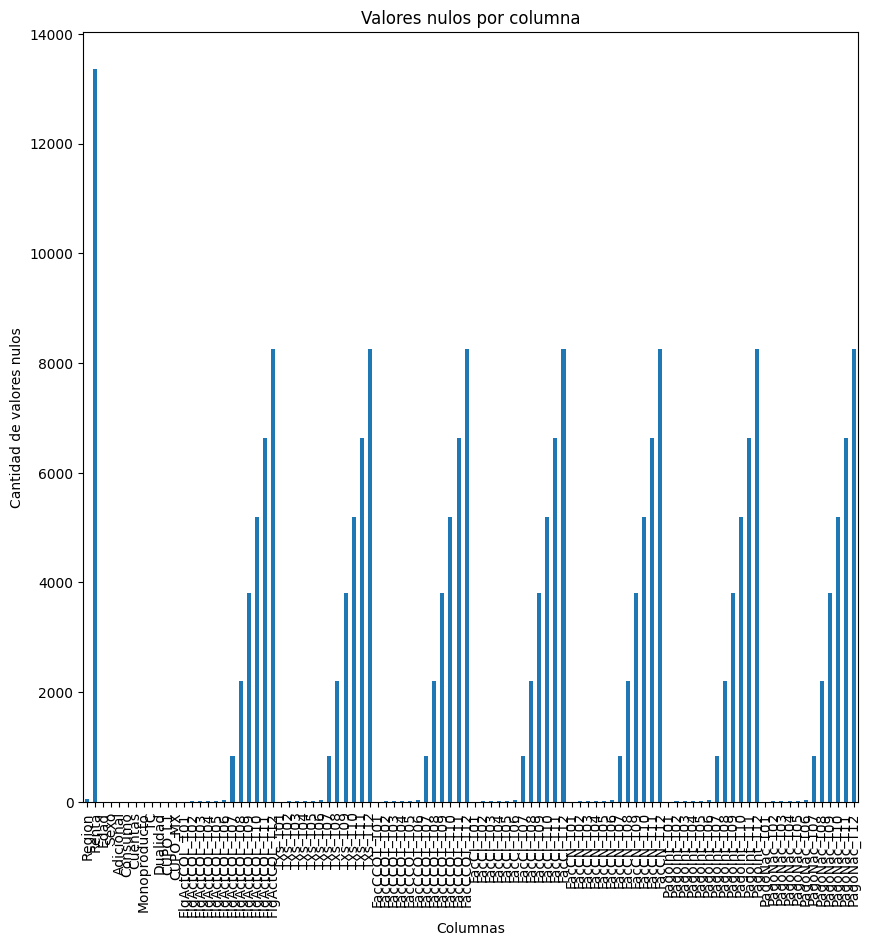

In [33]:
# Contar los valores nulos por columna
null_counts = df_monopoly.isnull().sum()

# Crear un gráfico de barras
plt.figure(figsize=(10, 10))
null_counts.plot(kind='bar')
plt.title('Valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

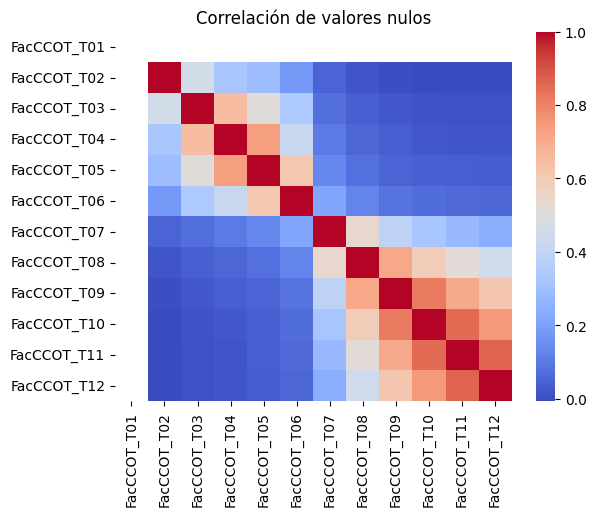

In [46]:
null_corr = df_monopoly[['FacCCOT_T01','FacCCOT_T02','FacCCOT_T03','FacCCOT_T04','FacCCOT_T05','FacCCOT_T06','FacCCOT_T07','FacCCOT_T08','FacCCOT_T09','FacCCOT_T10','FacCCOT_T11','FacCCOT_T12']].isnull().corr()

# Visualizar la matriz de correlación
sns.heatmap(null_corr, cmap='coolwarm')
plt.title('Correlación de valores nulos')
plt.show()

<h4>Imputar datos</h4>

A medida que analizamos los datos de los clientes a lo largo del tiempo, observamos que los valores nulos aumentaban en ciertos períodos, lo que puede ser atribuido a inconsistencias en la captura de datos o a periodos donde la información no fue registrada correctamente. Para evitar la pérdida de información valiosa y mantener la continuidad temporal de los datos, optamos por utilizar la interpolación lineal.

Respecto a la variable Renta se optó por imputar el valor mínimo de la renta para los casos en los que este dato faltaba. Esta decisión se basó al evaluar el riesgo crediticio de los clientes. Al asignar el valor mínimo, se garantiza que la capacidad de pago estimada no sea superior a la real, lo que reduce el riesgo de incumplimiento. 

Respecto a los nulos de las variables Sexo y Region simplemente se eliminaron sus filas debido a el minimo porcentaje que tenia de nulos siendo menor a 1%.

In [ ]:
# Seleccionamos las columnas a interpolar y usamos un bucle
columns_to_interpolate = [
    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08', 'FlgActCOL_T09', 'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
    'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
    'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
    'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
    'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
    'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
    'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12'
]

# Iteramos sobre las columnas para aplicar la interpolación
for column in columns_to_interpolate:
    df_monopoly[column] = df_monopoly[column].interpolate(method='linear')

#Rellenamos Renta con el valor minimo
df_monopoly['Renta'].fillna(df_monopoly['Renta'].min(), inplace=True)

#Eliminamos filas nulas de Sexo y Region
df_monopoly = df_monopoly.dropna(subset=['Sexo', 'Region'])

# Verificamos los resultados
print(df_monopoly[columns_to_interpolate].isnull().sum())


In [52]:
df_monopoly.isna().sum()

Region         0
Renta          0
Edad           0
Sexo           0
Adicional      0
              ..
PagoNac_T08    0
PagoNac_T09    0
PagoNac_T10    0
PagoNac_T11    0
PagoNac_T12    0
Length: 96, dtype: int64

## Creacion de variables:

In [53]:
# Calculando la suma de pagos de los últimos 12 meses
df_monopoly['Total_Deuda_Pagada'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']].sum(axis=1)

# Definiendo un umbral de pago (por ejemplo, 90% de las facturas)
df_monopoly['Total_Facturas'] =  df_monopoly[['FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
                                              'FacCN_T12', 'FacCN_T11', 'FacCN_T10', 'FacCN_T09', 'FacCN_T08', 'FacCN_T07', 'FacCN_T06', 'FacCN_T05', 'FacCN_T04', 'FacCN_T03', 'FacCN_T02', 'FacCN_T01']].sum(axis=1)

df_monopoly['Paga_al_dia'] = df_monopoly['Total_Deuda_Pagada'] >= df_monopoly['Total_Facturas']
df_monopoly['Paga_al_dia'] = df_monopoly['Paga_al_dia'].astype(int)


#Otra manera de hacerlo como ayuda para futuro:

#df_monopoly['Paga_al_dia'] = 0
#df_monopoly.loc[df_monopoly['total_pago'] >= umbral, 'Paga_al_dia'] = 1

df_monopoly

C:\Users\Eitan\AppData\Local\Temp\ipykernel_9924\2107869603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Total_Deuda_Pagada'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']].sum(axis=1)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_9924\2107869603.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,Region,Renta,Edad,Sexo,Adicional,Consumo,Cuentas,Monoproducto,TC,Dualidad,...,PagoNac_T06,PagoNac_T07,PagoNac_T08,PagoNac_T09,PagoNac_T10,PagoNac_T11,PagoNac_T12,Total_Deuda_Pagada,Total_Facturas,Paga_al_dia
0,13.0,1.0,43,M,1,0,1,0,3,0,...,36000.0,26000.0,25000.0,24000.0,23000.0,0.0,22000.0,352000.0,3.862230e+05,0
1,13.0,143640.0,46,H,0,0,1,0,1,0,...,100000.0,200000.0,180000.0,221000.0,194000.0,150000.0,250000.0,2009000.0,1.355021e+06,1
2,13.0,929106.0,45,H,1,0,1,0,2,0,...,124289.0,60886.0,0.0,45890.0,14850.0,178179.0,29990.0,819909.0,1.787789e+06,0
3,13.0,172447.0,46,H,1,0,1,1,2,0,...,60000.0,45000.0,60000.0,60000.0,40000.0,50000.0,80000.0,685000.0,4.142860e+05,1
4,13.0,805250.0,46,H,1,0,2,0,3,1,...,386774.0,431776.0,435450.0,272969.0,301404.0,245513.0,236467.0,3495806.0,3.527268e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,H,1,0,2,0,3,1,...,155000.0,80000.0,0.0,85000.0,80000.0,75000.0,50000.0,958000.0,8.268950e+05,1
51120,13.0,625376.0,51,H,0,0,1,0,1,0,...,346717.0,0.0,10336.0,45711.0,35454.0,37294.0,16358.0,1236737.0,1.384888e+06,0
51121,13.0,806220.0,47,H,1,0,1,0,2,0,...,13092.0,0.0,0.0,110298.0,10000.0,20000.0,60000.0,304087.0,1.691690e+05,1
51122,13.0,1.0,47,M,0,0,1,0,1,0,...,46256.0,42031.0,47510.0,0.0,0.0,46878.5,30000.0,379953.5,4.724520e+05,0


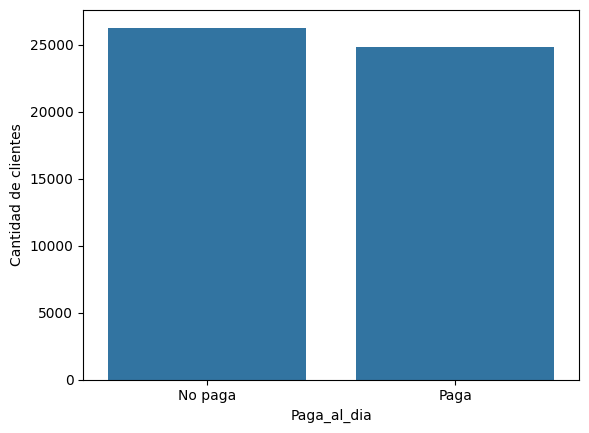

In [54]:
sns.countplot(x='Paga_al_dia', data=df_monopoly)
plt.xticks([0, 1], ['No paga', 'Paga'])
plt.ylabel('Cantidad de clientes')
plt.show()

<h4>Limpiamos las variables que queremos utilizar:</h4>

In [55]:
#Tranformamos columna sexo a 2 columnas de Hombre y Mujer
df_monopoly['Hombre'] = (df_monopoly['Sexo'] == 'H').astype(int)
df_monopoly['Mujer'] = (df_monopoly['Sexo'] == 'M').astype(int)
df_monopoly.drop('Sexo', axis=1, inplace=True)

C:\Users\Eitan\AppData\Local\Temp\ipykernel_9924\3732524898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Hombre'] = (df_monopoly['Sexo'] == 'H').astype(int)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_9924\3732524898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Mujer'] = (df_monopoly['Sexo'] == 'M').astype(int)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_9924\3732524898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

<h5>Reorganizamos las variables:</h5>

In [56]:
df_monopoly = df_monopoly.reindex(columns=['Region', 'Renta', 'Edad','Hombre','Mujer', 'Adicional','Consumo', 'Cuentas', 'Monoproducto' , 'TC', 'Dualidad', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                    'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
                    'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
                    'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
                    'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
                    'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
                    'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12',
                    'Total_Deuda_Pagada', 'Total_Facturas', 'Paga_al_dia'])

df_monopoly

,Region,Renta,Edad,Hombre,Mujer,Adicional,Consumo,Cuentas,Monoproducto,TC,...,PagoNac_T06,PagoNac_T07,PagoNac_T08,PagoNac_T09,PagoNac_T10,PagoNac_T11,PagoNac_T12,Total_Deuda_Pagada,Total_Facturas,Paga_al_dia
0,13.0,1.0,43,0,1,1,0,1,0,3,...,36000.0,26000.0,25000.0,24000.0,23000.0,0.0,22000.0,352000.0,3.862230e+05,0
1,13.0,143640.0,46,1,0,0,0,1,0,1,...,100000.0,200000.0,180000.0,221000.0,194000.0,150000.0,250000.0,2009000.0,1.355021e+06,1
2,13.0,929106.0,45,1,0,1,0,1,0,2,...,124289.0,60886.0,0.0,45890.0,14850.0,178179.0,29990.0,819909.0,1.787789e+06,0
3,13.0,172447.0,46,1,0,1,0,1,1,2,...,60000.0,45000.0,60000.0,60000.0,40000.0,50000.0,80000.0,685000.0,4.142860e+05,1
4,13.0,805250.0,46,1,0,1,0,2,0,3,...,386774.0,431776.0,435450.0,272969.0,301404.0,245513.0,236467.0,3495806.0,3.527268e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,1,0,1,0,2,0,3,...,155000.0,80000.0,0.0,85000.0,80000.0,75000.0,50000.0,958000.0,8.268950e+05,1
51120,13.0,625376.0,51,1,0,0,0,1,0,1,...,346717.0,0.0,10336.0,45711.0,35454.0,37294.0,16358.0,1236737.0,1.384888e+06,0
51121,13.0,806220.0,47,1,0,1,0,1,0,2,...,13092.0,0.0,0.0,110298.0,10000.0,20000.0,60000.0,304087.0,1.691690e+05,1
51122,13.0,1.0,47,0,1,0,0,1,0,1,...,46256.0,42031.0,47510.0,0.0,0.0,46878.5,30000.0,379953.5,4.724520e+05,0


In [67]:
df_simple = (df_monopoly[['Region','Renta','Edad','Hombre','Mujer','Adicional','Consumo','Cuentas','Monoproducto','TC','Dualidad','Total_Facturas','Total_Deuda_Pagada','Paga_al_dia']])
df_simple

,Region,Renta,Edad,Hombre,Mujer,Adicional,Consumo,Cuentas,Monoproducto,TC,Dualidad,Total_Facturas,Total_Deuda_Pagada,Paga_al_dia
0,13.0,1.0,43,0,1,1,0,1,0,3,0,3.862230e+05,352000.0,0
1,13.0,143640.0,46,1,0,0,0,1,0,1,0,1.355021e+06,2009000.0,1
2,13.0,929106.0,45,1,0,1,0,1,0,2,0,1.787789e+06,819909.0,0
3,13.0,172447.0,46,1,0,1,0,1,1,2,0,4.142860e+05,685000.0,1
4,13.0,805250.0,46,1,0,1,0,2,0,3,1,3.527268e+06,3495806.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,1,0,1,0,2,0,3,1,8.268950e+05,958000.0,1
51120,13.0,625376.0,51,1,0,0,0,1,0,1,0,1.384888e+06,1236737.0,0
51121,13.0,806220.0,47,1,0,1,0,1,0,2,0,1.691690e+05,304087.0,1
51122,13.0,1.0,47,0,1,0,0,1,0,1,0,4.724520e+05,379953.5,0


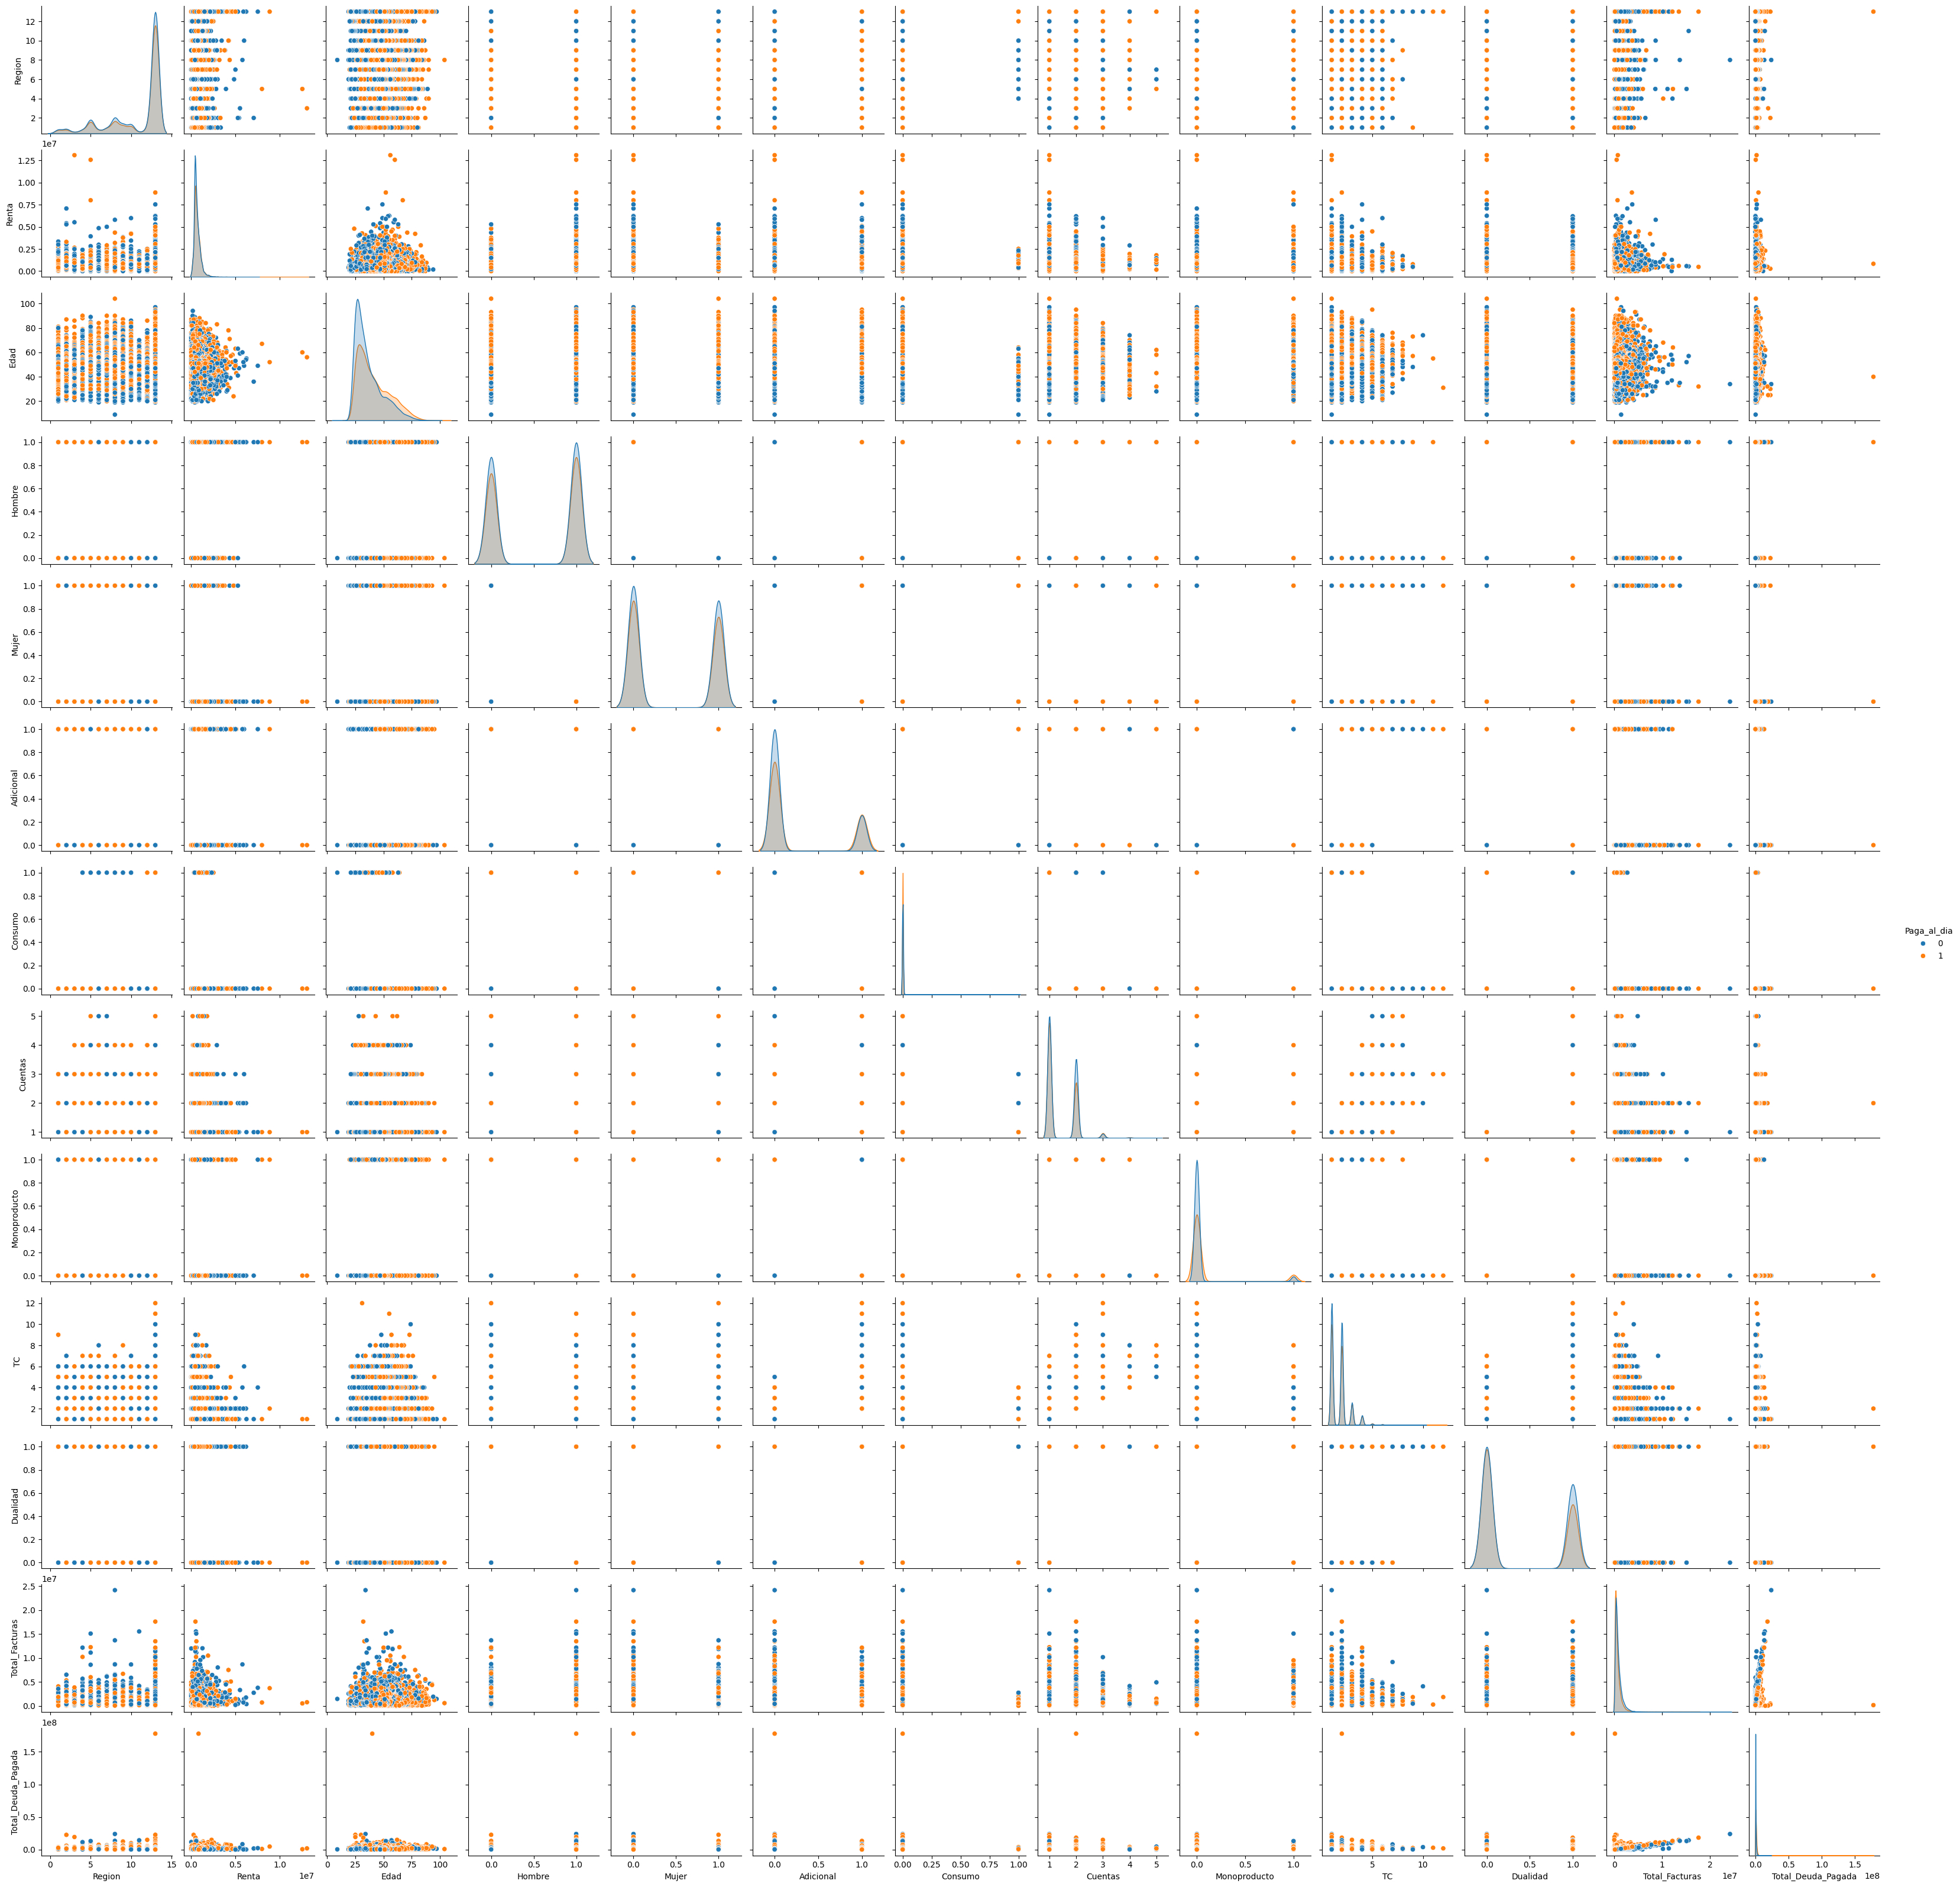

In [15]:
sns.pairplot(data=df_simple,hue='Paga_al_dia')

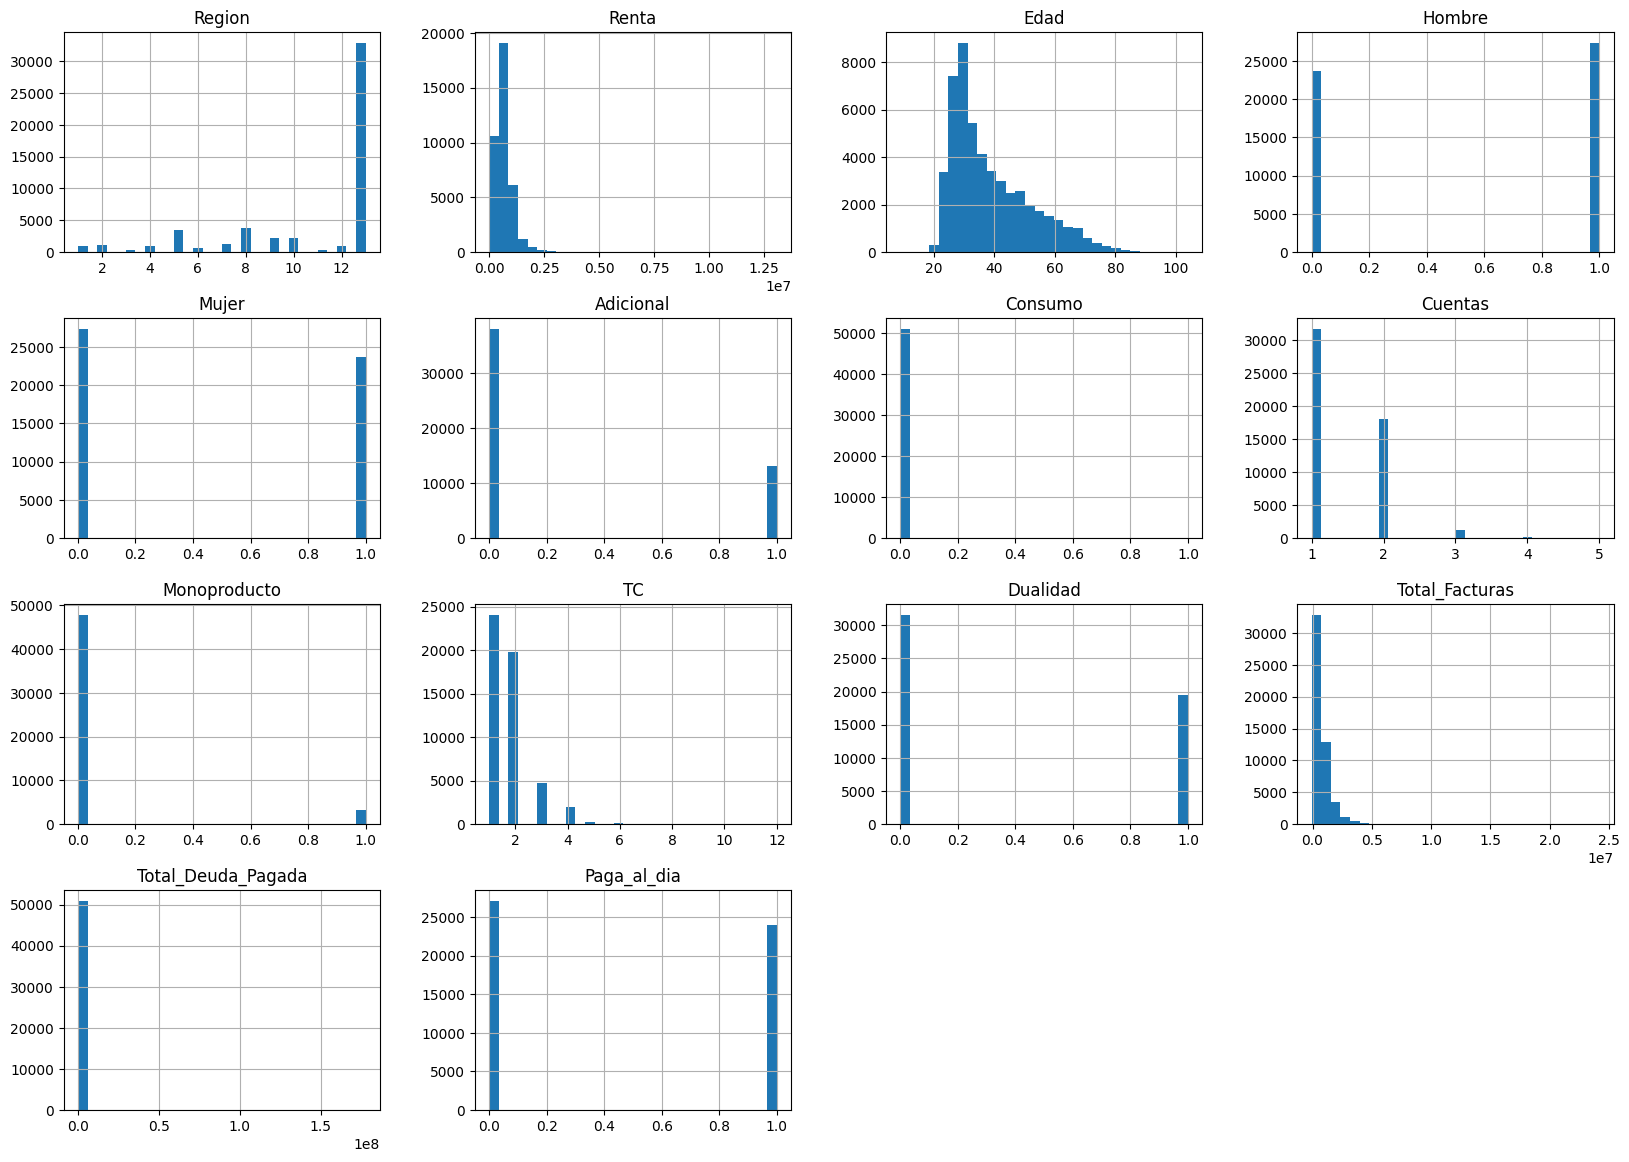

In [27]:
df_simple.hist(bins=30, figsize=(20, 14))
plt.show()

<h5>Dividimos en tipo de variables:</h5>

In [58]:
var_continuas = (df_monopoly[['Renta','CUPO_L1', 'CUPO_MX',
                            'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                            'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
                            'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
                            'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
                            'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
                            'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
                            'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12',
                            'Total_Deuda_Pagada', 'Total_Facturas' ]])

var_discretas = (df_monopoly[['Edad', 'Cuentas', 'TC']])

var_nominales = (df_monopoly[['Hombre', 'Mujer', 'Adicional', 'Consumo', 'Monoproducto', 'Dualidad', 'Paga_al_dia']])

var_ordinales = (df_monopoly[['Region']])

<h2>Fase 3: Data Preparation</h2>

<h4>Normalizamos y Estandarizamos las variables</h4>

In [112]:
df_monopoly_nor = df_monopoly.copy()

In [113]:
#Aqui limpiamos las variables:
for i in df_monopoly_nor.columns[:-2]:
    mean = df_monopoly_nor[i].mean()
    std = df_monopoly_nor[i].std()
    mini = df_monopoly_nor[i].min()
    maxi = df_monopoly_nor[i].max()

    if i not in ['Edad', 'Region', 'Cuentas', 'TC']:
        #Estandarizamos
        df_monopoly_nor[i] = df_monopoly_nor[i].apply(lambda x: (x - mean) / std)

    else:
        #Normalizamos
        df_monopoly_nor[i] = df_monopoly_nor[i].apply(lambda x: (x - mini) / (maxi - mini))

In [114]:
df_monopoly_nor

,Region,Renta,Edad,Hombre,Mujer,Adicional,Consumo,Cuentas,Monoproducto,TC,...,PagoNac_T06,PagoNac_T07,PagoNac_T08,PagoNac_T09,PagoNac_T10,PagoNac_T11,PagoNac_T12,Total_Deuda_Pagada,Total_Facturas,Paga_al_dia
0,1.0,-1.072600,0.282353,-1.075265,1.075265,1.703523,-0.029697,0.00,-0.259665,0.181818,...,-0.254670,-0.280369,-0.281067,-0.282268,-0.284325,-0.432706,-0.281715,-0.441637,3.862230e+05,0
1,1.0,-0.758174,0.317647,0.929985,-0.929985,-0.587007,-0.029697,0.00,-0.259665,0.000000,...,0.185728,0.910031,0.772907,0.990400,0.863693,0.482536,1.029666,0.963773,1.355021e+06,1
2,1.0,0.961217,0.305882,0.929985,-0.929985,1.703523,-0.029697,0.00,-0.259665,0.090909,...,0.352867,-0.041700,-0.451063,-0.140853,-0.339041,0.654473,-0.235759,-0.044773,1.787789e+06,0
3,1.0,-0.695115,0.317647,0.929985,-0.929985,1.703523,-0.029697,0.00,3.851034,0.090909,...,-0.089521,-0.150382,-0.043073,-0.049699,-0.170195,-0.127625,0.051882,-0.159198,4.142860e+05,1
4,1.0,0.690095,0.317647,0.929985,-0.929985,1.703523,-0.029697,0.25,-0.259665,0.181818,...,2.159085,2.495699,2.509925,1.326133,1.584756,1.065319,0.951828,2.224829,3.527268e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,1.0,-0.273663,0.376471,0.929985,-0.929985,1.703523,-0.029697,0.25,-0.259665,0.181818,...,0.564196,0.089066,-0.451063,0.111807,0.098347,0.024915,-0.120669,0.072351,8.268950e+05,1
51120,1.0,0.296350,0.376471,0.929985,-0.929985,-0.587007,-0.029697,0.00,-0.259665,0.000000,...,1.883444,-0.458244,-0.380780,-0.142010,-0.200715,-0.205153,-0.314166,0.308766,1.384888e+06,0
51121,1.0,0.692218,0.329412,0.929985,-0.929985,1.703523,-0.029697,0.00,-0.259665,0.090909,...,-0.412305,-0.458244,-0.451063,0.275238,-0.371602,-0.310674,-0.063152,-0.482275,1.691690e+05,1
51122,1.0,-1.072600,0.329412,-1.075265,1.075265,-0.587007,-0.029697,0.00,-0.259665,0.000000,...,-0.184096,-0.170694,-0.128003,-0.437314,-0.438737,-0.146672,-0.235702,-0.417928,4.724520e+05,0


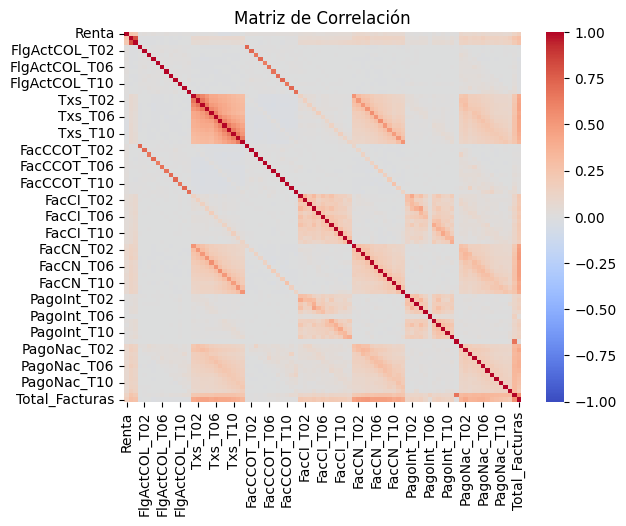

In [65]:
sns.heatmap(var_continuas.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

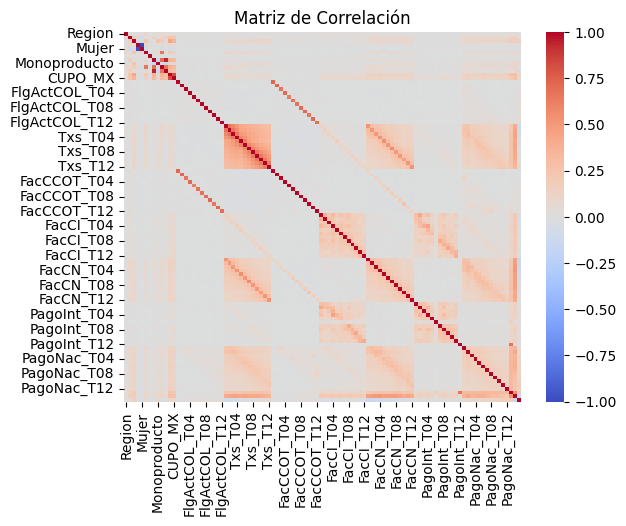

In [115]:
sns.heatmap(df_monopoly_nor.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

<h2>Fase 4: Modeling</h2>

In [32]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

<h3>Regresión</h3>

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [129]:
X = df_monopoly_nor[['Region', 'Renta', 'Edad','Hombre','Mujer', 'Adicional','Consumo', 'Cuentas', 'Monoproducto' , 'TC', 'Dualidad', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                    'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
                    'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
                    'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
                    'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
                    'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
                    'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12',
                    'Total_Facturas', 'Paga_al_dia']]
y = df_monopoly_nor['Total_Deuda_Pagada']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [130]:

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 1.1303565395596241e-19
R-squared: 1.0


In [118]:
# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

predictions_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(predictions_df.head(10))

r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

           Real  Predicción
33492 -0.628468   -0.767798
36153 -0.473485   -0.645325
20981 -0.513152   -0.642274
18565  0.763268    0.544408
22662 -0.364826   -0.114286
13248 -0.321722   -0.493948
44003 -0.134369   -0.198783
26990 -0.539009   -0.706989
30748 -0.485659   -0.647616
32280 -0.371690   -0.562804
Mean Squared Error: 0.1784453635545727
R-squared: 0.6676321442068867


In [126]:
from sklearn.linear_model import Ridge, Lasso

# Entrenamos el modelo Ridge
ridge_model = Ridge(alpha=1.0)  # alpha es el hiperparámetro de regularización
ridge_model.fit(X_train, y_train)
ridge_train_preds = ridge_model.predict(X_train)
ridge_test_preds = ridge_model.predict(X_test)


r2 = r2_score(y_train, ridge_train_preds)
print('Training de R-squared:', r2)
r2 = r2_score(y_test, ridge_test_preds)
print('Prueba de R-squared:', r2)

# Entrenamos el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el hiperparámetro de regularización
lasso_model.fit(X_train, y_train)
lasso_train_preds = lasso_model.predict(X_train)
lasso_test_preds = lasso_model.predict(X_test)

r2 = r2_score(y_train, lasso_train_preds)
print('\nTraining de R-squared:', r2)
r2 = r2_score(y_test, lasso_test_preds)
print('Prueba de R-squared:', r2)

c:\Users\Eitan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.05708e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training de R-squared: 0.34641361216653066
Prueba de R-squared: 0.6676411455986839

Training de R-squared: 0.29833595468525353
Prueba de R-squared: 0.5690879838683003


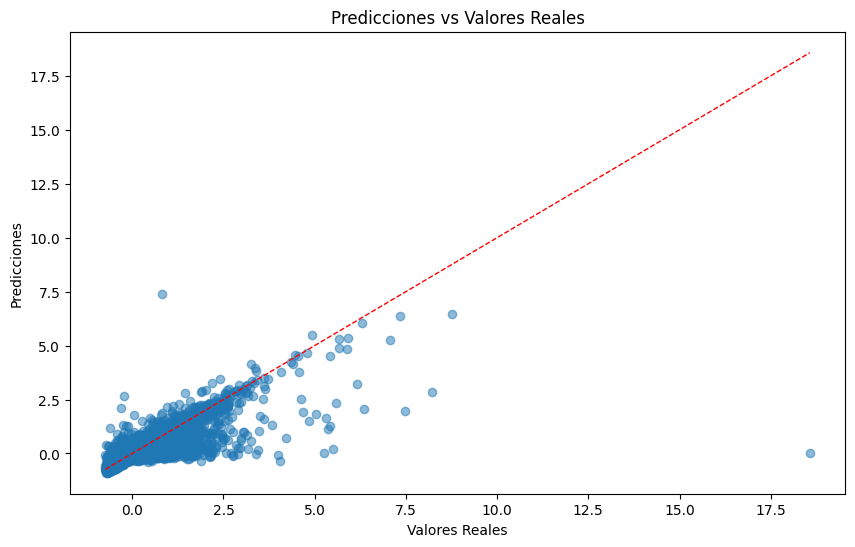

In [119]:

# Comparación de valores reales vs. predichos
# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [120]:

# Predicciones en el conjunto de entrenamiento
train_preds = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
print(f'Error cuadrático medio en el conjunto de entrenamiento: {train_mse:.2f}')

# Predicciones en el conjunto de prueba
test_preds = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
print(f'Error cuadrático medio en el conjunto de prueba: {test_mse:.2f}')

# Comparar los errores puede ayudar a determinar el sobreajuste
if train_mse < test_mse:
    print("El modelo podría estar sobreajustado.")

Error cuadrático medio en el conjunto de entrenamiento: 0.73
Error cuadrático medio en el conjunto de prueba: 0.18


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR

# Supongamos que tienes tus datos en X (características) y y (etiquetas continuas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

# Predicciones en el conjunto de entrenamiento
train_preds = model.predict(X_train)
train_r2 = r2_score(y_train, train_preds)
print(f'Coeficiente de determinación en el conjunto de entrenamiento (R^2): {train_r2:.2f}')

# Predicciones en el conjunto de prueba
test_preds = model.predict(X_test)
test_r2 = r2_score(y_test, test_preds)
print(f'Coeficiente de determinación en el conjunto de prueba (R^2): {test_r2:.2f}')

# Comparar los coeficientes de determinación
if train_r2 > test_r2:
    print("El modelo podría estar sobreajustado.")


Coeficiente de determinación en el conjunto de entrenamiento (R^2): 0.25
Coeficiente de determinación en el conjunto de prueba (R^2): 0.49


In [128]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Supongamos que tienes tus datos en X (características) y y (etiquetas continuas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Entrenamos el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Puedes ajustar el número de vecinos (k)
knn_model.fit(X_train, y_train)

# Predicciones en el conjunto de entrenamiento
train_preds = knn_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)
print(f'Error cuadrático medio en el conjunto de entrenamiento: {train_mse:.2f}')
print(f'Coeficiente de determinación en el conjunto de entrenamiento (R^2): {train_r2:.2f}')

# Predicciones en el conjunto de prueba
test_preds = knn_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
print(f'Error cuadrático medio en el conjunto de prueba: {test_mse:.2f}')
print(f'Coeficiente de determinación en el conjunto de prueba (R^2): {test_r2:.2f}')

# Comparar los errores y R^2 puede ayudar a determinar el sobreajuste
if train_mse < test_mse:
    print("El modelo podría estar sobreajustado.")


Error cuadrático medio en el conjunto de entrenamiento: 0.67
Coeficiente de determinación en el conjunto de entrenamiento (R^2): 0.40
Error cuadrático medio en el conjunto de prueba: 0.40
Coeficiente de determinación en el conjunto de prueba (R^2): 0.25


<h3>Clasificación</h3>

## Apuntes

Ver train y test para el modelo para ver si estan sobreajustado. Ambos deberian ser parecidos

Para solucionar en caso de sobreajustado revisar parametros o crossvalidation(K = 5 o K = 10). No hiperparametros